# Notebook 03: Segmentacion de Nodulos con nnU-Net

Este notebook implementa el pipeline completo para entrenar nnU-Net con mascaras de LIDC-IDRI.

**Caracteristica principal**: El notebook detecta automaticamente si los datos ya fueron preparados y salta las celdas correspondientes. Puedes ejecutar "Run All" sin preocuparte por duplicar trabajo.

## Contenido:
1. Configuracion del Entorno
2. Imports y Configuracion
3. Deteccion Automatica de Datos
4. Preparacion de Datos (NIfTI)
5. Crear dataset.json
6. Verificar Datos Convertidos
7. Preprocesamiento nnU-Net
8. Entrenamiento nnU-Net
9. Inferencia
10. Resumen

---

## 1. Configuracion del Entorno

In [ ]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

# ============================================================
# GUARDAR RESULTADOS EN GOOGLE DRIVE (solo Colab)
# Esto guarda preprocesamiento, pesos y resultados en Drive
# para no perderlos si la sesion se desconecta
# ============================================================
SAVE_TO_DRIVE = True  # Cambiar a False si no quieres usar Drive

if IN_COLAB:
    print("Ejecutando en Google Colab")
    print("="*50)
    
    # Instalar dependencias
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", 
                          "nnunetv2", "SimpleITK", "pylidc", "nibabel"])
    
    # Clonar repositorio
    repo_url = "https://github.com/Daspony/Imagenes-Biomedicas.git"
    if not os.path.exists("/content/Imagenes-Biomedicas"):
        subprocess.run(["git", "clone", repo_url], cwd="/content")
    sys.path.insert(0, "/content/Imagenes-Biomedicas")
    
    project_root = "/content/Imagenes-Biomedicas"
    
    # Montar Drive para guardar resultados
    if SAVE_TO_DRIVE:
        from google.colab import drive
        drive.mount('/content/drive')
        
        # Crear carpeta en Drive para resultados
        drive_nnunet = "/content/drive/MyDrive/nnUNet_results"
        os.makedirs(drive_nnunet, exist_ok=True)
        
        # Rutas nnU-Net en Google Drive (persistentes)
        os.environ['nnUNet_raw'] = os.path.join(drive_nnunet, 'nnUNet_raw')
        os.environ['nnUNet_preprocessed'] = os.path.join(drive_nnunet, 'nnUNet_preprocessed')
        os.environ['nnUNet_results'] = os.path.join(drive_nnunet, 'nnUNet_results')
        print(f"\n[OK] Resultados se guardaran en Google Drive")
        print(f"    {drive_nnunet}")
    else:
        # Rutas temporales (se pierden al desconectar)
        os.environ['nnUNet_raw'] = os.path.join(project_root, 'nnUNet_raw')
        os.environ['nnUNet_preprocessed'] = os.path.join(project_root, 'nnUNet_preprocessed')
        os.environ['nnUNet_results'] = os.path.join(project_root, 'nnUNet_results')
        print("\n[WARNING] Resultados NO se guardaran - se perderan al desconectar")
else:
    print("Ejecutando localmente")
    print("="*50)
    parent_dir = os.path.abspath('..')
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
    project_root = parent_dir
    
    # Rutas locales
    os.environ['nnUNet_raw'] = os.path.join(project_root, 'nnUNet_raw')
    os.environ['nnUNet_preprocessed'] = os.path.join(project_root, 'nnUNet_preprocessed')
    os.environ['nnUNet_results'] = os.path.join(project_root, 'nnUNet_results')

print(f"\nRutas nnU-Net:")
print(f"  raw: {os.environ['nnUNet_raw']}")
print(f"  preprocessed: {os.environ['nnUNet_preprocessed']}")
print(f"  results: {os.environ['nnUNet_results']}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
import warnings
import subprocess

import SimpleITK as sitk

from utils import LUNA16DataLoader, download_luna16
from utils.lidc_loader import LIDCAnnotationLoader

try:
    import nnunetv2
    print("[OK] nnU-Net v2 disponible")
    NNUNET_AVAILABLE = True
except ImportError:
    print("[WARNING] nnU-Net no instalado. Ejecutar: pip install nnunetv2")
    NNUNET_AVAILABLE = False

# ============================================================
# CONFIGURACION - Modificar segun necesidad
# ============================================================
SUBSET = 0  # Subset a procesar (0-9)
DATA_PATH = os.path.join(project_root, f"LUNA16/subset{SUBSET}")
ANNOTATIONS_PATH = os.path.join(project_root, "LUNA16/annotations.csv")

# Configuracion nnU-Net
DATASET_ID = 1
DATASET_NAME = f"Dataset{DATASET_ID:03d}_LungNodules"
CONFIG = "2d"  # 2d recomendado para GPUs con poca memoria
FOLD = 0

# Split
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RANDOM_SEED = 42

print(f"\nConfiguracion:")
print(f"  Subset: {SUBSET}")
print(f"  Data path: {DATA_PATH}")
print(f"  Dataset: {DATASET_NAME}")
print(f"  Config: {CONFIG}")

# Verificar/descargar datos
if not os.path.exists(DATA_PATH):
    print(f"\n[INFO] Datos no encontrados. Descargando subset{SUBSET}...")
    download_luna16(subsets=[SUBSET], output_dir=os.path.join(project_root, "LUNA16"))

if os.path.exists(DATA_PATH):
    n_files = len(list(Path(DATA_PATH).glob("*.mhd")))
    print(f"  [OK] {n_files} archivos .mhd encontrados")
else:
    print(f"  [ERROR] No se pudo descargar los datos")

print("\nLibrerias importadas")

In [3]:
# ============================================================
# DETECCION AUTOMATICA - No modificar
# ============================================================
dataset_path = os.path.join(os.environ['nnUNet_raw'], DATASET_NAME)
dataset_json_path = os.path.join(dataset_path, 'dataset.json')
imagesTr_path = os.path.join(dataset_path, 'imagesTr')
labelsTr_path = os.path.join(dataset_path, 'labelsTr')

# Verificar que existan los archivos necesarios, no solo las carpetas
def verify_data_prepared():
    if not os.path.exists(dataset_json_path):
        return False, "dataset.json no existe"
    
    if not os.path.exists(imagesTr_path) or not os.path.exists(labelsTr_path):
        return False, "Carpetas imagesTr/labelsTr no existen"
    
    n_images = len(list(Path(imagesTr_path).glob("*.nii.gz")))
    n_labels = len(list(Path(labelsTr_path).glob("*.nii.gz")))
    
    if n_images == 0:
        return False, "imagesTr esta vacio"
    if n_labels == 0:
        return False, "labelsTr esta vacio"
    if n_images != n_labels:
        return False, f"Mismatch: {n_images} imagenes vs {n_labels} labels"
    
    return True, f"{n_images} casos verificados"

DATA_ALREADY_PREPARED, verify_msg = verify_data_prepared()

if DATA_ALREADY_PREPARED:
    print("[OK] Datos ya preparados - las celdas de preparacion se saltaran automaticamente")
    print(f"    Dataset: {dataset_path}")
    print(f"    {verify_msg}")
    
    # Cargar info existente
    with open(dataset_json_path, 'r') as f:
        existing_info = json.load(f)
    
    # Cargar split existente
    split_path = os.path.join(os.environ['nnUNet_raw'], 'data_split.json')
    if os.path.exists(split_path):
        with open(split_path, 'r') as f:
            split_info = json.load(f)
        train_ids = split_info.get('train', [])
        val_ids = split_info.get('val', [])
        test_ids = split_info.get('test', [])
        print(f"    Split: Train={len(train_ids)}, Val={len(val_ids)}, Test={len(test_ids)}")
    else:
        print("[WARNING] data_split.json no encontrado")
        train_ids, val_ids, test_ids = [], [], []
else:
    print("[INFO] Datos no preparados - ejecutando preparacion completa")
    print(f"       Razon: {verify_msg}")

[OK] Datos ya preparados - las celdas de preparacion se saltaran automaticamente
    Dataset: c:\Users\Poney\Desktop\Imagenes Biomedicas\nnUNet_raw\Dataset001_LungNodules
    56 casos verificados
    Split: Train=46, Val=10, Test=11


In [4]:
# Verificar mascaras LIDC disponibles
if not DATA_ALREADY_PREPARED:
    lidc_loader = LIDCAnnotationLoader(verbose=False)
    
    # Cargar anotaciones LUNA16
    annotations_df = pd.read_csv(ANNOTATIONS_PATH)
    mhd_files = list(Path(DATA_PATH).glob("*.mhd"))
    available_seriesuids = [f.stem for f in mhd_files]
    annotations_subset = annotations_df[annotations_df['seriesuid'].isin(available_seriesuids)]
    seriesuids_with_nodules = annotations_subset['seriesuid'].unique()
    
    scans_info = []
    print("Verificando mascaras LIDC...")
    for seriesuid in tqdm(seriesuids_with_nodules):
        scan = lidc_loader.get_scan_by_seriesuid(seriesuid)
        if scan is not None:
            clusters = scan.cluster_annotations()
            if len(clusters) > 0:
                scans_info.append({
                    'seriesuid': seriesuid,
                    'num_nodules': len(clusters),
                    'num_annotations': sum(len(c) for c in clusters)
                })
    
    scans_df = pd.DataFrame(scans_info)
    print(f"\\nScans con mascaras LIDC: {len(scans_df)}")
else:
    print("[SKIP] Datos ya preparados")

[SKIP] Datos ya preparados


In [5]:
# Split train/val/test
if not DATA_ALREADY_PREPARED:
    from sklearn.model_selection import train_test_split
    
    TRAIN_RATIO = 0.70
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    RANDOM_SEED = 42
    
    all_seriesuids = scans_df['seriesuid'].tolist()
    train_ids, temp_ids = train_test_split(all_seriesuids, train_size=TRAIN_RATIO, random_state=RANDOM_SEED)
    val_ids, test_ids = train_test_split(temp_ids, train_size=0.5, random_state=RANDOM_SEED)
    
    print(f"Split: Train={len(train_ids)}, Val={len(val_ids)}, Test={len(test_ids)}")
else:
    print("[SKIP] Datos ya preparados")

[SKIP] Datos ya preparados


In [6]:
# Guardar split
if not DATA_ALREADY_PREPARED:
    split_info = {'train': train_ids, 'val': val_ids, 'test': test_ids, 'seed': RANDOM_SEED}
    os.makedirs(os.environ['nnUNet_raw'], exist_ok=True)
    split_path = os.path.join(os.environ['nnUNet_raw'], 'data_split.json')
    with open(split_path, 'w') as f:
        json.dump(split_info, f, indent=2)
    print(f"Split guardado: {split_path}")
else:
    print("[SKIP] Datos ya preparados")

[SKIP] Datos ya preparados


## 4. Preparar Datos en Formato nnU-Net

Estructura requerida:
```
nnUNet_raw/Dataset001_LungNodules/
  imagesTr/case_0000_0000.nii.gz
  labelsTr/case_0000.nii.gz
  imagesTs/...
  dataset.json
```

In [7]:
# Crear carpetas y definir rutas
dataset_path = os.path.join(os.environ['nnUNet_raw'], DATASET_NAME)
imagesTr = os.path.join(dataset_path, 'imagesTr')
labelsTr = os.path.join(dataset_path, 'labelsTr')
imagesTs = os.path.join(dataset_path, 'imagesTs')
labelsTs = os.path.join(dataset_path, 'labelsTs')

if not DATA_ALREADY_PREPARED:
    for p in [imagesTr, labelsTr, imagesTs, labelsTs]:
        os.makedirs(p, exist_ok=True)
    print(f"[OK] Carpetas creadas en: {dataset_path}")
else:
    print("[SKIP] Carpetas ya existen")

[SKIP] Carpetas ya existen


In [8]:
# Funciones de conversion (siempre disponibles para visualizacion)
loader = LUNA16DataLoader(DATA_PATH)

def create_nodule_mask(seriesuid, ct_shape, origin, spacing, lidc_loader):
    """Crea mascara de nodulos desde LIDC."""
    mask = np.zeros(ct_shape, dtype=np.uint8)
    
    scan = lidc_loader.get_scan_by_seriesuid(seriesuid)
    if scan is None:
        return mask, 0
    
    clusters = scan.cluster_annotations()
    num_nodules = 0
    
    for cluster in clusters:
        result = lidc_loader.get_aligned_mask_for_cluster(
            cluster=cluster, origin=origin, spacing=spacing,
            ct_shape=ct_shape, threshold=0.5
        )
        if result is not None:
            nodule_mask, bbox = result
            z_sl, y_sl, x_sl = bbox
            mask[z_sl, y_sl, x_sl] = np.maximum(
                mask[z_sl, y_sl, x_sl], nodule_mask.astype(np.uint8)
            )
            num_nodules += 1
    
    return mask, num_nodules

def save_nifti(volume, origin, spacing, path):
    """Guarda volumen como NIfTI."""
    img = sitk.GetImageFromArray(volume)
    img.SetSpacing([float(spacing[2]), float(spacing[1]), float(spacing[0])])
    img.SetOrigin([float(origin[2]), float(origin[1]), float(origin[0])])
    sitk.WriteImage(img, path)

print("[OK] Funciones definidas")

[OK] Funciones definidas


In [9]:
# Convertir datos de Train y Val a NIfTI
if not DATA_ALREADY_PREPARED:
    train_val_ids = train_ids + val_ids
    print(f"Procesando {len(train_val_ids)} scans (train + val)...")
    processed = []
    
    for idx, seriesuid in enumerate(tqdm(train_val_ids)):
        try:
            ct_path = os.path.join(DATA_PATH, f"{seriesuid}.mhd")
            ct_scan, origin, spacing = loader.load_itk_image(ct_path)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                mask, num_nodules = create_nodule_mask(
                    seriesuid, ct_scan.shape, origin, spacing, lidc_loader
                )
            
            case_id = f"case_{idx:04d}"
            save_nifti(ct_scan, origin, spacing, os.path.join(imagesTr, f"{case_id}_0000.nii.gz"))
            save_nifti(mask, origin, spacing, os.path.join(labelsTr, f"{case_id}.nii.gz"))
            
            processed.append({'case_id': case_id, 'seriesuid': seriesuid, 'nodules': num_nodules})
        except Exception as e:
            print(f"[ERROR] {seriesuid}: {e}")
    
    print(f"\n[OK] Train+Val: {len(processed)} casos procesados")
else:
    print("[SKIP] Datos ya preparados")
    # Listar archivos y extraer case_id (formato: case_XXXX_0000.nii.gz)
    processed = []
    for f in sorted(Path(imagesTr).glob("case_*_0000.nii.gz")):
        # case_0000_0000.nii.gz -> case_0000
        filename = f.name  # case_0000_0000.nii.gz
        case_id = filename.rsplit('_', 1)[0]  # Quita _0000.nii.gz -> case_0000
        processed.append({'case_id': case_id})
    print(f"       {len(processed)} casos de entrenamiento encontrados")
    if processed:
        print(f"       Ejemplo: {processed[0]['case_id']}")

[SKIP] Datos ya preparados
       56 casos de entrenamiento encontrados
       Ejemplo: case_0000


In [10]:
# Convertir datos de Test a NIfTI
if not DATA_ALREADY_PREPARED:
    print(f"Procesando {len(test_ids)} scans para test...")
    test_processed = []
    offset = len(train_val_ids)
    
    for idx, seriesuid in enumerate(tqdm(test_ids)):
        try:
            ct_path = os.path.join(DATA_PATH, f"{seriesuid}.mhd")
            ct_scan, origin, spacing = loader.load_itk_image(ct_path)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                mask, num_nodules = create_nodule_mask(
                    seriesuid, ct_scan.shape, origin, spacing, lidc_loader
                )
            
            case_id = f"case_{offset + idx:04d}"
            save_nifti(ct_scan, origin, spacing, os.path.join(imagesTs, f"{case_id}_0000.nii.gz"))
            save_nifti(mask, origin, spacing, os.path.join(labelsTs, f"{case_id}.nii.gz"))
            
            test_processed.append({'case_id': case_id, 'seriesuid': seriesuid, 'nodules': num_nodules})
        except Exception as e:
            print(f"[ERROR] {seriesuid}: {e}")
    
    print(f"\n[OK] Test: {len(test_processed)} casos procesados")
else:
    print("[SKIP] Datos ya preparados")
    # Listar archivos y extraer case_id
    test_processed = []
    for f in sorted(Path(imagesTs).glob("case_*_0000.nii.gz")):
        filename = f.name
        case_id = filename.rsplit('_', 1)[0]
        test_processed.append({'case_id': case_id})
    print(f"       {len(test_processed)} casos de test encontrados")

[SKIP] Datos ya preparados
       11 casos de test encontrados


## 5. Crear dataset.json

In [11]:
# Crear dataset.json
if not DATA_ALREADY_PREPARED:
    dataset_json = {
        "channel_names": {"0": "CT"},
        "labels": {"background": 0, "nodule": 1},
        "numTraining": len(processed),
        "file_ending": ".nii.gz",
        "name": "LungNodules",
        "description": "Lung nodule segmentation LUNA16 + LIDC-IDRI"
    }
    
    json_path = os.path.join(dataset_path, 'dataset.json')
    with open(json_path, 'w') as f:
        json.dump(dataset_json, f, indent=2)
    
    print("[OK] dataset.json guardado")
    print(json.dumps(dataset_json, indent=2))
else:
    print("[SKIP] dataset.json ya existe")
    with open(dataset_json_path, 'r') as f:
        print(json.dumps(json.load(f), indent=2))

[SKIP] dataset.json ya existe
{
  "channel_names": {
    "0": "CT"
  },
  "labels": {
    "background": 0,
    "nodule": 1
  },
  "numTraining": 56,
  "file_ending": ".nii.gz",
  "name": "LungNodules",
  "description": "Lung nodule segmentation LUNA16 + LIDC-IDRI"
}


## 6. Verificar Datos Convertidos

In [12]:
# Verificar archivos generados
n_imagesTr = len(list(Path(imagesTr).glob("*.nii.gz")))
n_labelsTr = len(list(Path(labelsTr).glob("*.nii.gz")))
n_imagesTs = len(list(Path(imagesTs).glob("*.nii.gz")))
n_labelsTs = len(list(Path(labelsTs).glob("*.nii.gz")))

print("Archivos NIfTI generados:")
print(f"  imagesTr: {n_imagesTr}")
print(f"  labelsTr: {n_labelsTr}")
print(f"  imagesTs: {n_imagesTs}")
print(f"  labelsTs: {n_labelsTs}")

if n_imagesTr == n_labelsTr and n_imagesTr > 0:
    print("\n[OK] Datos verificados - listos para preprocesamiento")
else:
    print("\n[WARNING] Verificar que las cantidades sean correctas")

Archivos NIfTI generados:
  imagesTr: 56
  labelsTr: 56
  imagesTs: 11
  labelsTs: 11

[OK] Datos verificados - listos para preprocesamiento


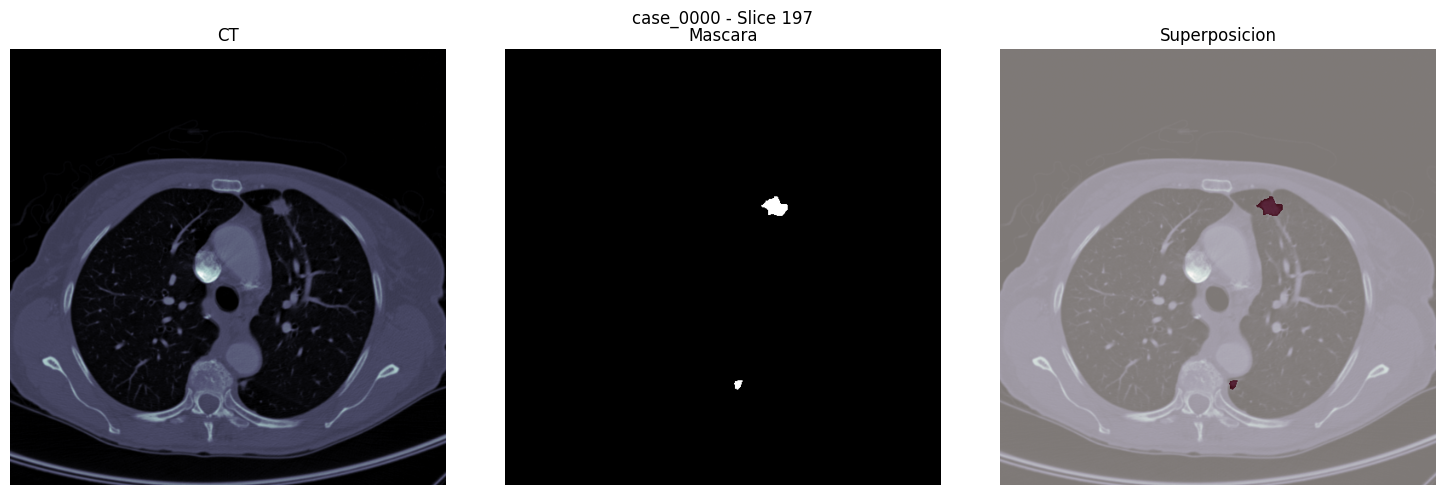

In [13]:
# Visualizar ejemplo de datos convertidos
if len(processed) > 0:
    case = processed[0]
    case_id = case['case_id'] if isinstance(case, dict) else case
    
    ct_path = os.path.join(imagesTr, f"{case_id}_0000.nii.gz")
    mask_path = os.path.join(labelsTr, f"{case_id}.nii.gz")
    
    if os.path.exists(ct_path) and os.path.exists(mask_path):
        ct_nii = sitk.ReadImage(ct_path)
        mask_nii = sitk.ReadImage(mask_path)
        
        ct = sitk.GetArrayFromImage(ct_nii)
        mask = sitk.GetArrayFromImage(mask_nii)
        
        # Buscar slice con nodulo
        z_nodule = np.where(np.any(mask, axis=(1,2)))[0]
        if len(z_nodule) > 0:
            z = z_nodule[len(z_nodule)//2]
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(ct[z], cmap='bone')
            axes[0].set_title('CT')
            axes[1].imshow(mask[z], cmap='gray')
            axes[1].set_title('Mascara')
            axes[2].imshow(ct[z], cmap='bone')
            axes[2].imshow(mask[z], cmap='Reds', alpha=0.5)
            axes[2].set_title('Superposicion')
            for ax in axes: ax.axis('off')
            plt.suptitle(f"{case_id} - Slice {z}")
            plt.tight_layout()
            plt.show()
        else:
            print("[INFO] No se encontraron nodulos en este caso")
    else:
        print(f"[WARNING] Archivos no encontrados: {case_id}")
else:
    print("[INFO] No hay casos procesados para visualizar")

## 7. Preprocesamiento nnU-Net

Este paso analiza los datos y crea planes de preprocesamiento optimizados.

In [14]:
# Preprocesamiento nnU-Net
preprocessed_path = os.path.join(os.environ['nnUNet_preprocessed'], DATASET_NAME)

def verify_preprocessing_done():
    if not os.path.exists(preprocessed_path):
        return False, "Carpeta no existe"
    
    # nnU-Net crea nnUNetPlans.json durante el preprocesamiento
    plans_path = os.path.join(preprocessed_path, 'nnUNetPlans.json')
    if not os.path.exists(plans_path):
        return False, "nnUNetPlans.json no existe"
    
    # Verificar que existan datos preprocesados
    configs = [d for d in os.listdir(preprocessed_path) 
               if os.path.isdir(os.path.join(preprocessed_path, d)) and d.startswith('nnUNetPlans')]
    if not configs:
        return False, "No hay configuraciones preprocesadas"
    
    return True, f"Configuraciones: {', '.join(configs)}"

PREPROCESS_DONE, preprocess_msg = verify_preprocessing_done()

if PREPROCESS_DONE:
    print("[OK] Preprocesamiento ya completado")
    print(f"    Datos en: {preprocessed_path}")
    print(f"    {preprocess_msg}")
elif NNUNET_AVAILABLE:
    print(f"[INFO] {preprocess_msg}")
    print("Ejecutando preprocesamiento nnU-Net...")
    print("Tiempo estimado: 5-15 minutos (solo se ejecuta una vez)")
    print("="*60)
    
    process = subprocess.Popen(
        ["nnUNetv2_plan_and_preprocess", "-d", str(DATASET_ID), "--verify_dataset_integrity"],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )
    
    for line in process.stdout:
        print(line, end='')
    
    process.wait()
    print("="*60)
    if process.returncode == 0:
        print("[OK] Preprocesamiento completado")
    else:
        print(f"[ERROR] Codigo de salida: {process.returncode}")
else:
    print("[WARNING] nnU-Net no disponible")
    print("Comando para ejecutar manualmente:")
    print(f"  nnUNetv2_plan_and_preprocess -d {DATASET_ID} --verify_dataset_integrity")

[INFO] nnUNetPlans.json no existe
Ejecutando preprocesamiento nnU-Net...
Tiempo estimado: 5-15 minutos (solo se ejecuta una vez)
Fingerprint extraction...
Dataset001_LungNodules
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Attempting to find 3d_lowres config. 
Current spacing: [1.2875     0.72421875 0.72421875]. 
Current patch size: (np.int64(80), np.int64(192), np.int64(160)). 
Current median shape: [242.7184466  497.08737864 497.08737864]
Attempting to find 3d_lowres config. 
Current spacing: [1.3

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 8: character maps to <undefined>

## 8. Entrenamiento nnU-Net

Configuracion recomendada:
- **2d**: Mas rapido, menor uso de memoria (recomendado para RTX 2050/3060)
- **3d_fullres**: Mejor precision, requiere mas VRAM (12GB+)

In [ ]:
# Entrenamiento nnU-Net
results_path = os.path.join(os.environ['nnUNet_results'], DATASET_NAME)

def verify_training_done():
    """Verifica si el entrenamiento ya se completo."""
    if not os.path.exists(results_path):
        return False, "Carpeta de resultados no existe"
    
    # Buscar checkpoint final
    trainer_path = os.path.join(results_path, f"nnUNetTrainer__nnUNetPlans__{CONFIG}")
    if not os.path.exists(trainer_path):
        return False, f"No hay modelo {CONFIG}"
    
    fold_path = os.path.join(trainer_path, f"fold_{FOLD}")
    if not os.path.exists(fold_path):
        return False, f"No hay fold_{FOLD}"
    
    # Verificar checkpoint final
    checkpoint = os.path.join(fold_path, "checkpoint_final.pth")
    if os.path.exists(checkpoint):
        return True, f"Modelo entrenado en: {fold_path}"
    
    # Verificar checkpoint parcial (entrenamiento interrumpido)
    checkpoint_latest = os.path.join(fold_path, "checkpoint_latest.pth")
    if os.path.exists(checkpoint_latest):
        return False, f"Entrenamiento incompleto - checkpoint parcial existe"
    
    return False, "No hay checkpoints"

TRAINING_DONE, training_msg = verify_training_done()

if TRAINING_DONE:
    print("[OK] Entrenamiento ya completado")
    print(f"    {training_msg}")
elif NNUNET_AVAILABLE:
    print(f"[INFO] {training_msg}")
    print(f"Entrenando nnU-Net (config={CONFIG}, fold={FOLD})...")
    print("Tiempo estimado: 2-6 horas para 2D, 6-24 horas para 3D")
    print("="*60)
    
    process = subprocess.Popen(
        ["nnUNetv2_train", str(DATASET_ID), CONFIG, str(FOLD)],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )
    
    for line in process.stdout:
        print(line, end='')
    
    process.wait()
    print("="*60)
    if process.returncode == 0:
        print("[OK] Entrenamiento completado")
    else:
        print(f"[ERROR] Codigo de salida: {process.returncode}")
else:
    print("[WARNING] nnU-Net no disponible")
    print("Comando para ejecutar manualmente:")
    print(f"  nnUNetv2_train {DATASET_ID} {CONFIG} {FOLD}")

## 9. Inferencia

Prediccion en nuevos datos usando el modelo entrenado.

In [ ]:
# Inferencia nnU-Net
output_dir = os.path.join(os.environ['nnUNet_results'], DATASET_NAME, 'predictions')

def verify_inference_done():
    """Verifica si la inferencia ya se completo."""
    if not os.path.exists(output_dir):
        return False, "Carpeta de predicciones no existe"
    
    predictions = list(Path(output_dir).glob("*.nii.gz"))
    if len(predictions) == 0:
        return False, "No hay predicciones"
    
    # Comparar con casos de test
    if len(predictions) >= len(test_processed):
        return True, f"{len(predictions)} predicciones encontradas"
    
    return False, f"Inferencia incompleta: {len(predictions)}/{len(test_processed)}"

INFERENCE_DONE, inference_msg = verify_inference_done()

if INFERENCE_DONE:
    print("[OK] Inferencia ya completada")
    print(f"    {inference_msg}")
    print(f"    Predicciones en: {output_dir}")
elif not TRAINING_DONE:
    print("[SKIP] Esperando que termine el entrenamiento")
    print("       Ejecuta la celda de entrenamiento primero")
elif NNUNET_AVAILABLE:
    print(f"[INFO] {inference_msg}")
    os.makedirs(output_dir, exist_ok=True)
    print(f"Ejecutando inferencia en datos de test...")
    print(f"Salida: {output_dir}")
    print("="*60)
    
    process = subprocess.Popen(
        ["nnUNetv2_predict", "-i", imagesTs, "-o", output_dir, 
         "-d", str(DATASET_ID), "-c", CONFIG, "-f", str(FOLD)],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        bufsize=1
    )
    
    for line in process.stdout:
        print(line, end='')
    
    process.wait()
    print("="*60)
    if process.returncode == 0:
        print("[OK] Inferencia completada")
    else:
        print(f"[ERROR] Codigo de salida: {process.returncode}")
else:
    print("[WARNING] nnU-Net no disponible")
    print("Comando para ejecutar manualmente:")
    print(f"  nnUNetv2_predict -i {imagesTs} -o {output_dir} -d {DATASET_ID} -c {CONFIG} -f {FOLD}")

## 10. Resumen

In [ ]:
# Resumen del pipeline
print("="*60)
print("RESUMEN DEL PIPELINE")
print("="*60)
print(f"\nDataset: {DATASET_NAME}")
print(f"Configuracion: {CONFIG}")
print(f"Fold: {FOLD}")
print(f"\nDatos:")
print(f"  Training: {len(processed)} casos")
print(f"  Test: {len(test_processed)} casos")
print(f"\nSplit:")
print(f"  Train: {len(train_ids)}")
print(f"  Val: {len(val_ids)}")
print(f"  Test: {len(test_ids)}")
print(f"\nRutas:")
print(f"  Raw: {os.environ['nnUNet_raw']}")
print(f"  Preprocessed: {os.environ['nnUNet_preprocessed']}")
print(f"  Results: {os.environ['nnUNet_results']}")
print(f"\nComandos CLI (alternativa):")
print(f"  1. nnUNetv2_plan_and_preprocess -d {DATASET_ID} --verify_dataset_integrity")
print(f"  2. nnUNetv2_train {DATASET_ID} {CONFIG} {FOLD}")
print(f"  3. nnUNetv2_predict -i {imagesTs} -o predictions -d {DATASET_ID} -c {CONFIG} -f {FOLD}")